<a href="https://colab.research.google.com/github/fjme95/python-para-la-ciencia-de-datos/blob/main/Semana%203/AdaBoost_Detecci%C3%B3n_de_fallas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dependencias

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt

# Datos

Los datos con los que trabajaremos se pueden descargar [aqui](https://challengedata.ens.fr/participants/challenges/58/). Contiene un archivo ```7z``` que contiene las imagenes del reto.

Alternativamente, hay ligas en el notebook para descargar una versión más ligera del dataset que se obtuvo al redimensionar las imágenes a 150x128.

Las imágenes reescaladas se encuentran en un archivo ```feather``` para facilitar la lectura de los datos a un DataFrame.

Cada fila corresponde a una imagen y cada columna a sus pixeles.

## Descarga

In [2]:
!gdown --id 1R3DDOqbW3FElSGHNChdtVgE_gTqar2PY
!gdown --id 1UZD50PnVMuuUg4J7zhBEdpT4caYeyIDY

Downloading...
From: https://drive.google.com/uc?id=1R3DDOqbW3FElSGHNChdtVgE_gTqar2PY
To: /content/data.feather
100% 547M/547M [00:04<00:00, 118MB/s]
Downloading...
From: https://drive.google.com/uc?id=1UZD50PnVMuuUg4J7zhBEdpT4caYeyIDY
To: /content/y_train_ExZpBft.csv
100% 361k/361k [00:00<00:00, 2.63MB/s]


## Lectura

In [3]:
y = pd.read_csv('/content/y_train_ExZpBft.csv')
y

,images,labels
0,AE00474_105028_00_4_3_2001.jpg,0
1,AE00305_043057_00_2_4_2001.jpg,1
2,AE00191_071651_00_2_2_2001.jpg,1
3,AE00191_103659_00_2_1_2001.jpg,1
4,AE00227_204647_00_3_4_2001.jpg,1
...,...,...
10604,AE00453_220334_00_4_1_2001.jpg,0
10605,AE00409_050952_00_4_2_2001.jpg,0
10606,AE00466_013823_00_1_3_2001.jpg,0
10607,AE00405_043052_00_1_4_2001.jpg,0


In [4]:
images = pd.read_feather('/content/data.feather')
images

,images,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,p21,p22,p23,p24,p25,p26,p27,p28,p29,p30,p31,p32,p33,p34,p35,p36,p37,p38,...,p19160,p19161,p19162,p19163,p19164,p19165,p19166,p19167,p19168,p19169,p19170,p19171,p19172,p19173,p19174,p19175,p19176,p19177,p19178,p19179,p19180,p19181,p19182,p19183,p19184,p19185,p19186,p19187,p19188,p19189,p19190,p19191,p19192,p19193,p19194,p19195,p19196,p19197,p19198,p19199
0,AE00474_105028_00_4_3_2001.jpg,44,43,44,45,45,47,48,46,51,48,47,48,50,48,46,44,47,47,49,48,52,55,116,229,238,239,239,239,239,239,239,239,239,239,239,239,239,239,239,...,241,236,239,241,239,240,239,236,243,234,237,241,239,224,159,89,81,64,63,54,48,58,61,61,50,53,53,93,185,234,237,238,239,239,239,239,239,239,239,239
1,AE00305_043057_00_2_4_2001.jpg,47,48,51,53,48,50,48,55,48,45,47,52,52,47,47,52,47,51,51,49,50,50,48,46,48,51,54,48,50,49,46,47,44,49,60,70,93,192,234,...,48,46,48,49,53,57,103,217,236,238,238,241,237,237,244,241,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239
2,AE00191_071651_00_2_2_2001.jpg,49,48,54,56,49,46,48,47,52,52,51,50,50,48,46,47,50,49,49,50,50,51,50,50,51,50,51,53,46,49,51,51,49,59,122,185,232,239,238,...,50,48,48,47,48,55,84,169,234,240,240,239,239,240,240,238,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239
3,AE00191_103659_00_2_1_2001.jpg,50,50,55,51,50,52,52,56,50,51,52,53,52,52,53,55,53,54,54,51,56,53,51,47,53,53,55,52,51,53,49,47,48,53,57,87,164,232,239,...,49,52,49,56,63,69,117,219,237,240,240,239,238,239,240,238,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239
4,AE00227_204647_00_3_4_2001.jpg,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239,237,235,161,79,56,47,27,33,75,68,93,199,236,238,238,...,181,60,42,40,39,39,39,41,38,44,45,39,42,40,39,37,42,38,41,39,37,37,38,55,178,238,239,239,239,239,237,239,239,239,239,239,239,239,239,239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10604,AE00453_220334_00_4_1_2001.jpg,50,53,47,47,47,50,45,45,46,47,49,48,48,49,47,51,48,48,54,53,61,118,229,237,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239,...,238,239,239,240,241,238,236,238,238,235,239,238,238,231,190,121,78,57,41,34,34,44,67,78,51,30,30,46,126,222,241,238,238,237,236,240,241,238,234,216
10605,AE00409_050952_00_4_2_2001.jpg,53,52,48,47,46,50,43,44,45,48,49,47,47,49,50,48,45,50,50,51,59,93,217,237,238,238,239,239,239,239,239,239,239,239,239,239,239,239,239,...,240,240,239,238,238,236,236,240,238,240,237,237,241,234,203,145,101,61,56,40,39,61,78,90,168,224,243,243,237,237,238,240,239,239,239,239,239,239,239,239
10606,AE00466_013823_00_1_3_2001.jpg,237,235,230,181,94,56,39,34,32,28,37,30,22,19,15,13,12,13,12,11,14,19,22,22,23,65,174,235,238,239,236,239,239,233,218,104,38,18,14,...,238,238,238,238,238,238,238,238,237,237,238,191,100,70,60,52,51,57,49,47,47,50,53,56,54,53,51,49,47,46,46,47,47,46,44,45,50,52,51,50
10607,AE00405_043052_00_1_4_2001.jpg,186,129,153,206,205,215,190,92,57,43,25,40,65,56,48,47,34,23,17,12,9,12,12,11,13,10,17,16,16,20,40,110,191,236,235,237,239,240,237,...,238,238,238,238,238,238,238,238,240,236,239,239,217,111,65,55,52,51,50,47,40,44,48,49,48,46,43,47,47,55,49,50,45,49,50,47,47,46,44,49


## Exploración

In [5]:
y.set_index('images', inplace = True)
images.set_index('images', inplace=True)

In [6]:
y.labels.value_counts()

1    6582
0    4027
Name: labels, dtype: int64

In [7]:
np.array(images.iloc[0, :]).reshape((150, 128))

array([[ 44,  43,  44, ..., 113,  64,  55],
       [ 46,  46,  47, ..., 180,  82,  61],
       [ 48,  49,  51, ..., 226, 124,  67],
       ...,
       [171, 148, 127, ..., 239, 239, 239],
       [220, 206, 186, ..., 239, 239, 239],
       [239, 235, 233, ..., 239, 239, 239]])

In [8]:
def plot_images(rows, columns, images, title=""):
    fig = plt.figure(figsize=(15, 10))
    fig.suptitle(title, fontsize=16)

    ax = []

    for i in range(columns*rows):
        img = np.array(images.iloc[i]).reshape(150, 128)
        ax.append( fig.add_subplot(rows, columns, i+1) )
        plt.imshow(img, cmap='gray')
    # fig.tight_layout()
    
    fig.show()

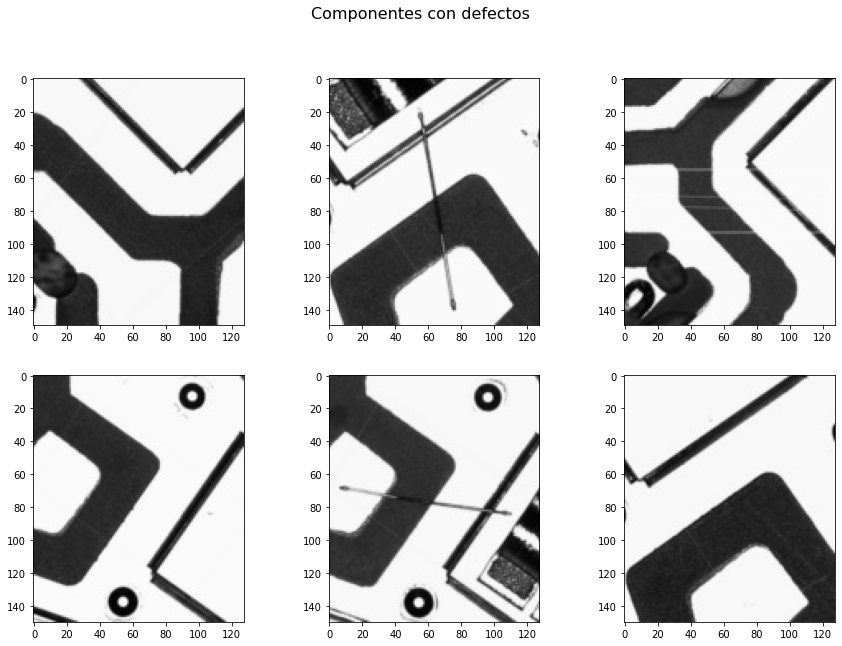

In [9]:
rows = 2
columns = 3

plot_images(rows, columns, images[y.labels == 0].sample(rows*columns, random_state = 10), "Componentes con defectos")

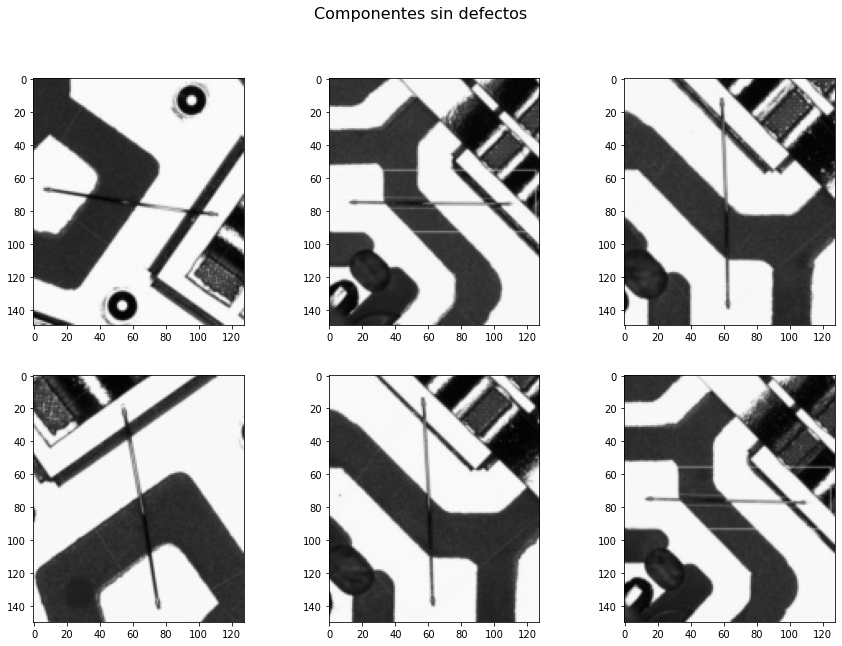

In [10]:
plot_images(rows, columns, images[y.labels == 1].sample(rows*columns, random_state = 10), "Componentes sin defectos")

## División en set de prueba y entrenamiento

In [11]:
X_train, X_test, y_train, y_test = train_test_split(images, y, train_size = .7, random_state = 10)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7426, 19200) (3183, 19200) (7426, 1) (3183, 1)


# Clasificación

## Árbol de decisión

In [12]:
clf_tree = DecisionTreeClassifier(max_depth = 2)
tree_train_pred = clf_tree.fit(X_train, y_train.labels.ravel()).predict(X_train)
print(classification_report(y_train, tree_train_pred, digits = 3))

              precision    recall  f1-score   support

           0      0.930     0.912     0.921      2795
           1      0.947     0.959     0.953      4631

    accuracy                          0.941      7426
   macro avg      0.939     0.935     0.937      7426
weighted avg      0.941     0.941     0.941      7426



In [13]:
tree_test_pred = clf_tree.predict(X_test)
print(classification_report(y_test, tree_test_pred, digits = 3))

              precision    recall  f1-score   support

           0      0.934     0.906     0.920      1232
           1      0.942     0.960     0.950      1951

    accuracy                          0.939      3183
   macro avg      0.938     0.933     0.935      3183
weighted avg      0.939     0.939     0.939      3183



In [14]:
print('\nSet de entrenamiento:')
print(confusion_matrix(y_train, tree_train_pred))
print('\nSet de prueba:')
print(confusion_matrix(y_test, tree_test_pred))


Set de entrenamiento:
[[2548  247]
 [ 191 4440]]

Set de prueba:
[[1116  116]
 [  79 1872]]


## AdaBoost (Árboles de decisión con boosting)

In [15]:
clf_ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2))

ada_train_pred = clf_ada.fit(X_train, y_train.labels.ravel()).predict(X_train)

print(classification_report(y_train, ada_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2795
           1       1.00      1.00      1.00      4631

    accuracy                           1.00      7426
   macro avg       1.00      1.00      1.00      7426
weighted avg       1.00      1.00      1.00      7426



In [16]:
ada_test_pred = clf_ada.predict(X_test)

print(classification_report(y_test, ada_test_pred, digits = 3))

              precision    recall  f1-score   support

           0      0.989     0.977     0.983      1232
           1      0.986     0.993     0.990      1951

    accuracy                          0.987      3183
   macro avg      0.988     0.985     0.986      3183
weighted avg      0.987     0.987     0.987      3183



In [17]:
print('\nSet de entrenamiento:')
print(confusion_matrix(y_train, ada_train_pred))
print('\nSet de prueba:')
print(confusion_matrix(y_test, ada_test_pred))


Set de entrenamiento:
[[2795    0]
 [   0 4631]]

Set de prueba:
[[1204   28]
 [  13 1938]]


In [23]:
errores = y_test.labels != ada_test_pred
errores

images
AE00411_122935_00_4_3_2001.jpg    False
AE00379_181107_00_3_1_2001.jpg    False
AE00305_094322_00_3_3_2001.jpg    False
AE00367_103115_00_3_2_2001.jpg    False
AE00453_184149_00_1_1_2001.jpg    False
                                  ...  
AE00405_171113_00_4_3_2001.jpg    False
AE00497_155323_00_4_3_2001.jpg    False
AE00348_070417_00_3_2_2001.jpg    False
AE00191_010655_00_3_2_2001.jpg    False
AE00389_022140_00_1_2_2001.jpg    False
Name: labels, Length: 3183, dtype: bool

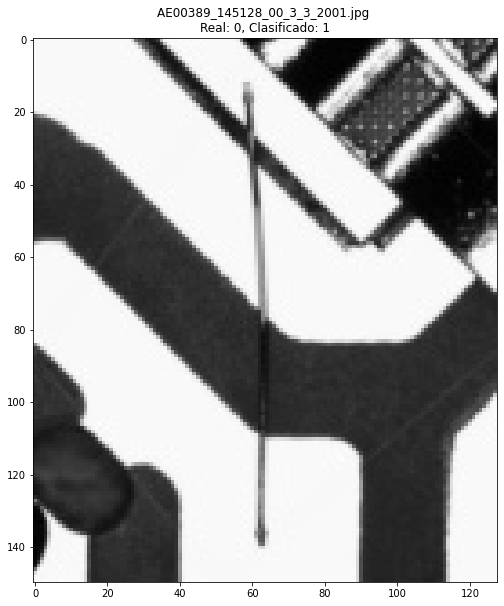

In [44]:
index = np.random.randint(0, len(errores[errores]))

plt.figure(figsize=(10, 10))
plt.imshow(np.array(X_test[errores].iloc[index, :]).reshape(150, 128), cmap = 'gray')
plt.title(f'{y_test[errores].index[index]} \nReal: {y_test[errores].values[index][0]}, Clasificado: {ada_test_pred[errores][index]}')
plt.show()

## Sobre el árbol de decisión

In [45]:
# https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py

n_nodes = clf_tree.tree_.node_count
children_left = clf_tree.tree_.children_left
children_right = clf_tree.tree_.children_right
feature = clf_tree.tree_.feature
threshold = clf_tree.tree_.threshold

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print(
    "The binary tree structure has {n} nodes and has "
    "the following tree structure:\n".format(n=n_nodes)
)
for i in range(n_nodes):
    if is_leaves[i]:
        print(
            "{space}node={node} is a leaf node.".format(
                space=node_depth[i] * "\t", node=i
            )
        )
    else:
        print(
            "{space}node={node} is a split node: "
            "go to node {left} if X[:, {feature}] <= {threshold} "
            "else to node {right}.".format(
                space=node_depth[i] * "\t",
                node=i,
                left=children_left[i],
                feature=feature[i],
                threshold=threshold[i],
                right=children_right[i],
            )
        )

The binary tree structure has 7 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, 13766] <= 66.5 else to node 4.
	node=1 is a split node: go to node 2 if X[:, 4735] <= 235.5 else to node 3.
		node=2 is a leaf node.
		node=3 is a leaf node.
	node=4 is a split node: go to node 5 if X[:, 9381] <= 39.5 else to node 6.
		node=5 is a leaf node.
		node=6 is a leaf node.


## Visualización del árbol

In [46]:
from sklearn import tree

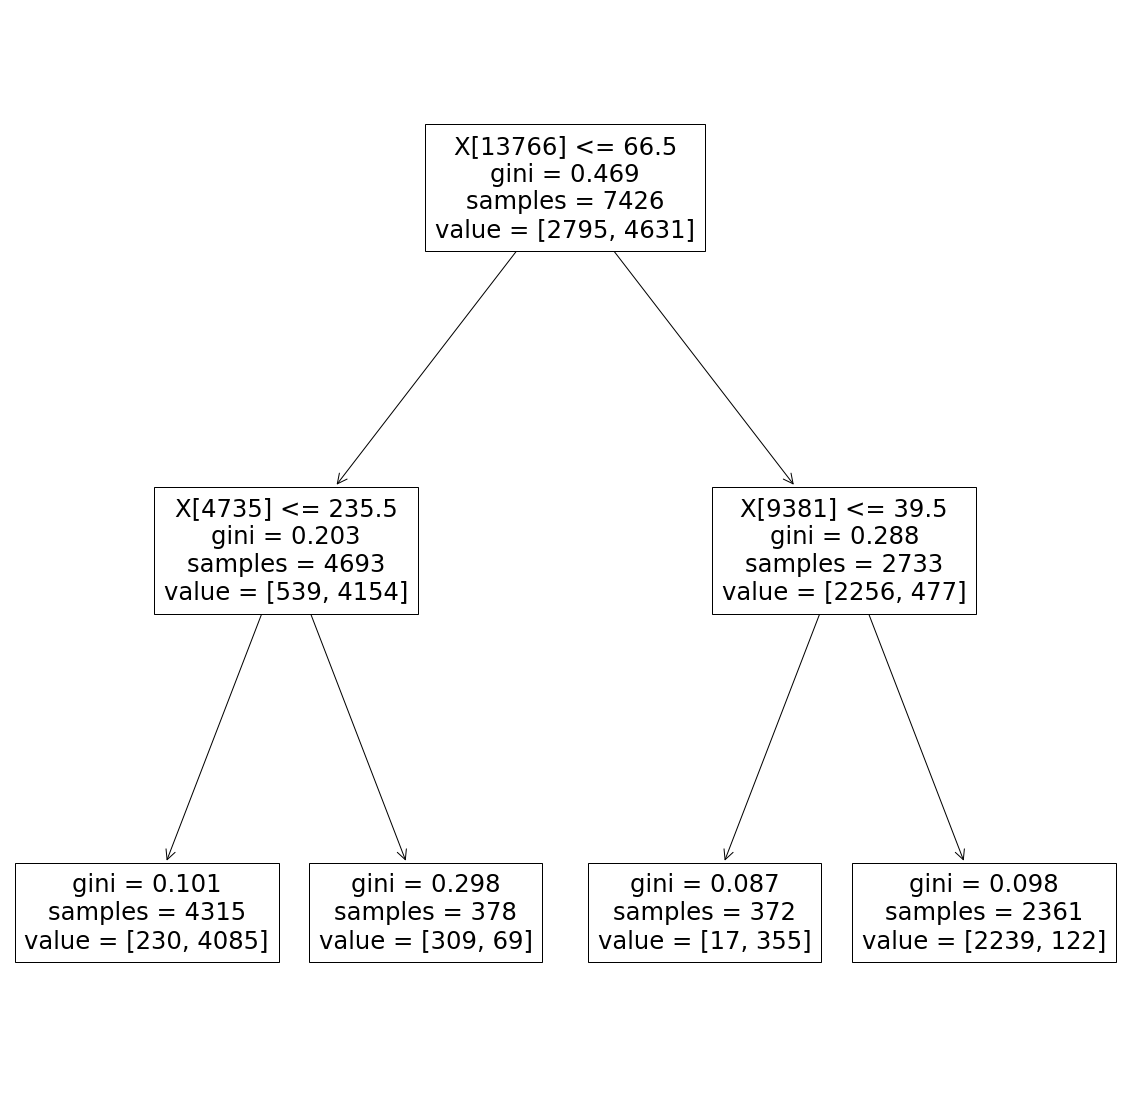

In [47]:
plt.figure(figsize=(20, 20))
tree.plot_tree(clf_tree)
plt.show()

## Pixeles en los que se basa el árbol para clasificar

In [48]:
def pos2coord(pos, cols):
    return pos//cols, pos%cols

In [49]:
coords = [pos2coord(x,128) for x in clf_tree.tree_.feature[clf_tree.tree_.feature != -2]]
coords

[(107, 70), (36, 127), (73, 37)]

In [51]:
from matplotlib.patches import Circle
from matplotlib.patheffects import withStroke

def plot_images_circle(rows, columns, images, circles, title=""):
    fig = plt.figure(figsize=(15, 10))
    fig.suptitle(title, fontsize=16)

    ax = []

    for i in range(columns*rows):
        img = np.array(images.iloc[i]).reshape(150, 128)
        ax.append( fig.add_subplot(rows, columns, i+1) )
        for circle in circles:
            ax[-1].add_artist(Circle(circle[::-1], 2, clip_on=False, zorder=10, linewidth=1,
                        edgecolor='black', facecolor=(0, 0, 0, .0125),
                        path_effects=[withStroke(linewidth=3, foreground='w')]))
        plt.imshow(img, cmap='gray')
    # fig.tight_layout()
    
    fig.show()

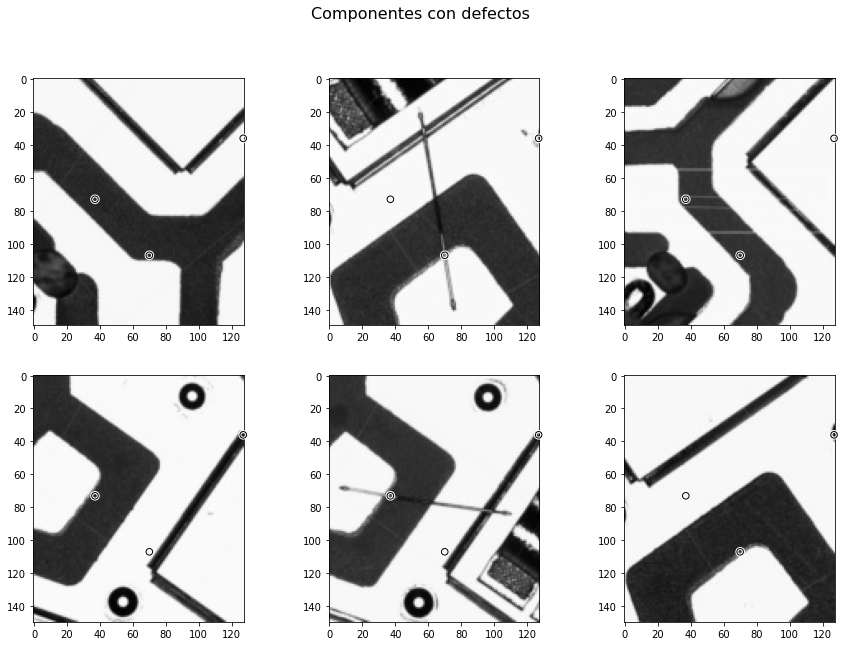

In [52]:
rows = 2
columns = 3
plot_images_circle(rows, columns, images[y.labels == 0].sample(rows*columns, random_state = 10), coords, "Componentes con defectos")

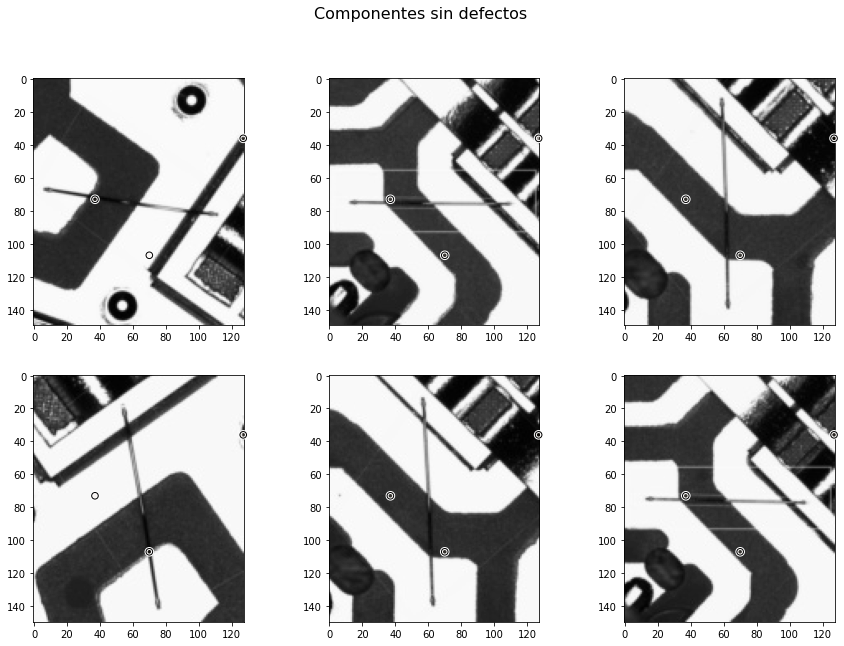

In [53]:
plot_images_circle(rows, columns, images[y.labels == 1].sample(rows*columns, random_state = 10), coords, "Componentes sin defectos")